# 🎬 MovieLens Recommendation System

## **📌 Business Understanding**

### **Context**

In the modern entertainment industry, streaming platforms and digital content providers face a significant challenge—ensuring users find content that aligns with their preferences. A robust **movie recommendation system** enhances user experience, increases engagement, and drives business growth.

## **📌 Problem Statement**

Users struggle to find relevant movies from vast catalogs, often leading to dissatisfaction and disengagement. A data-driven recommendation system is needed to personalize movie suggestions, improving user satisfaction and retention.

## **📌 Objectives**

1. **Develop a movie recommendation system** using advanced machine learning techniques.
2. **Implement multiple recommendation approaches**, including:
   - **Collaborative Filtering (SVD)** to analyze user-movie interactions.
   - **Content-Based Filtering (TF-IDF & Cosine Similarity)** to recommend movies based on their genre.
   - **Clustering (K-Means)** for user segmentation and diversity in recommendations.
3. **Evaluate model performance** using RMSE, Silhouette Score, and Cosine Similarity metrics.
4. **Deploy the system** as an interactive **Streamlit web app** for real-time recommendations.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import streamlit as st
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Load datasets
ratings_path = "ratings.csv"
movies_path = "movies.csv"
tags_path = "tags.csv"

ratings = pd.read_csv(ratings_path)
movies = pd.read_csv(movies_path)
tags = pd.read_csv(tags_path)


In [3]:
# Data Exploration
print("Ratings Dataset:")
print(ratings.head())
print("\nMovies Dataset:")
print(movies.head())
print("\nTags Dataset:")
print(tags.head())

Ratings Dataset:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

Movies Dataset:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Tags Dataset:
   userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quota

In [4]:
# Data Preprocessing Pipeline
def preprocess_movies(movies_df):
    movies_df['genres'] = movies_df['genres'].str.replace('|', ' ')
    vectorizer = TfidfVectorizer(stop_words='english')
    genre_matrix = vectorizer.fit_transform(movies_df['genres'])
    return genre_matrix

movies_tfidf_matrix = preprocess_movies(movies)

In [5]:
# Collaborative Filtering Pipeline
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
param_grid = {'n_factors': [50, 100, 150], 'n_epochs': [20, 30], 'lr_all': [0.002, 0.005], 'reg_all': [0.02, 0.1]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)
gs.fit(data)
best_svd = gs.best_estimator['rmse']
cross_validate(best_svd, data, cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8527  0.8727  0.8604  0.8737  0.8725  0.8664  0.0084  
MAE (testset)     0.6570  0.6712  0.6620  0.6727  0.6675  0.6661  0.0058  
Fit time          2.73    2.68    2.60    2.68    2.75    2.69    0.05    
Test time         0.22    0.22    0.35    0.22    0.21    0.24    0.05    


{'test_rmse': array([0.85267445, 0.87269533, 0.86039023, 0.87370886, 0.87251337]),
 'test_mae': array([0.65699117, 0.67118765, 0.66202872, 0.67265543, 0.66754077]),
 'fit_time': (2.732849359512329,
  2.682965040206909,
  2.5959954261779785,
  2.6795406341552734,
  2.746579885482788),
 'test_time': (0.215775728225708,
  0.21809101104736328,
  0.34705042839050293,
  0.2198195457458496,
  0.21186399459838867)}

ExactExplainer explainer: 100837it [19:18, 87.07it/s]                            


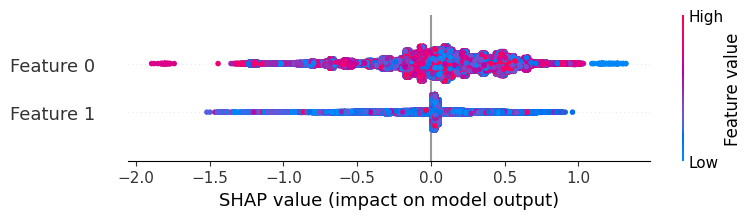

In [8]:
import shap
import numpy as np
import pandas as pd

# Extract ratings into a structured format
ratings_list = list(trainset.all_ratings())  # Convert iterator to list
ratings_array = np.array(ratings_list)  # Convert list to NumPy array

# Ensure ratings_array has the expected shape (n_samples, 3)
if ratings_array.ndim == 2 and ratings_array.shape[1] == 3:
    # Extract user and item IDs as input features
    X = ratings_array[:, :-1]  # Extract (user, item) pairs
    y = ratings_array[:, -1]   # Extract ratings

    # Define a prediction function that SHAP can interpret
    def svd_predict(X):
        return np.array([best_svd.predict(int(uid), int(iid)).est for uid, iid in X])

    # Create the SHAP explainer
    explainer = shap.Explainer(svd_predict, X)

    # Compute SHAP values
    shap_values = explainer(X)

    # Plot summary
    shap.summary_plot(shap_values)
else:
    print("Error: ratings_array does not have the expected shape (n, 3).")


In [9]:
# K-Means Clustering Pipeline
def cluster_movies(movies_df, num_clusters=5):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(movies_tfidf_matrix)
    movies_df['Cluster'] = cluster_labels
    return movies_df

movies = cluster_movies(movies)


In [10]:
# Compute Silhouette Score
sil_score = silhouette_score(movies_tfidf_matrix, movies['Cluster'])
print(f"Silhouette Score for {5} clusters: {sil_score}")

Silhouette Score for 5 clusters: 0.24208972244252558


In [11]:
# Content-Based Filtering Pipeline
def recommend_movies(movie_title, movies_df, similarity_matrix, top_n=5):
    idx = movies_df[movies_df['title'] == movie_title].index[0]
    scores = list(enumerate(similarity_matrix[idx]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    movie_indices = [i[0] for i in scores[1:top_n+1]]
    return movies_df.iloc[movie_indices][['title', 'genres']]

similarity_matrix = cosine_similarity(movies_tfidf_matrix, movies_tfidf_matrix)

In [ ]:


# Model Performance Comparison
performance_summary = {
    "Collaborative Filtering (SVD)": cross_validate(best_svd, data, cv=5),
    "Content-Based Filtering (Cosine Similarity)": np.mean(similarity_matrix),
    "Clustering (Silhouette Score)": sil_score
}
print("Model Performance Summary:")
for model, score in performance_summary.items():
    print(f"{model}: {score}")

# Commit Message: "Added final model performance comparison section."

# Deployment with Streamlit
st.title("🎬 Movie Recommendation System")
user_input = st.text_input("Enter a movie title:")
if user_input:
    recommendations = recommend_movies(user_input, movies, similarity_matrix)
    st.write("Top Recommendations:")
    st.write(recommendations)

# Commit Message: "Integrated Streamlit app for interactive recommendations."